In [1]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

cudnn.benchmark = True

## Load Data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

DATA_PATH = os.path.join(os.environ['DEV_PATH'], 'datasets/paddy-disease-classification')
TRAIN_PATH = os.path.join(DATA_PATH, 'train_images')
TEST_PATH = os.path.join(DATA_PATH, 'test_images')

image_dataset = datasets.ImageFolder(TRAIN_PATH, data_transforms['train'])
train, val = random_split(image_dataset, [0.8, 0.2])
image_datasets = {'train': train, 'val': val}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=32,
        shuffle=True,
        num_workers=4
    ) for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_dataset.classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Visualize a few images

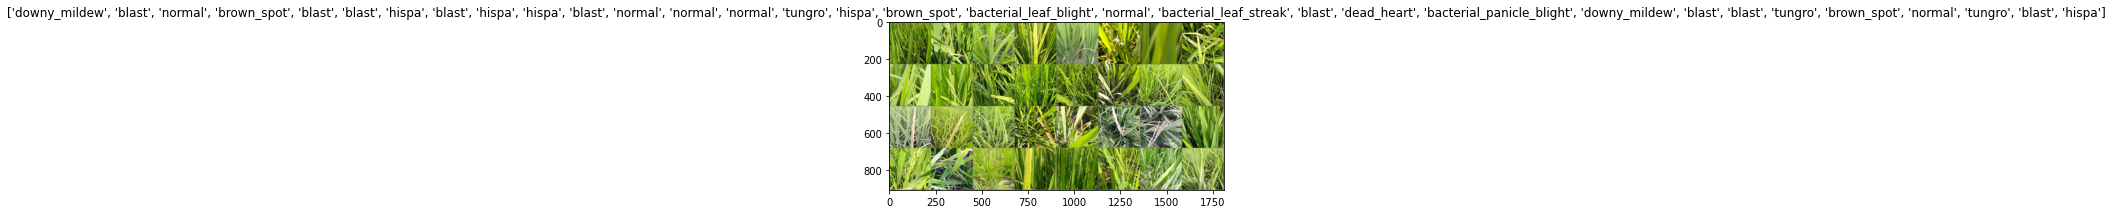

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.2250])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Obser that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\posky\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\posky\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and evaluate

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4925 Acc: 0.4923
val Loss: 0.9818 Acc: 0.6732

Epoch 1/24
----------
train Loss: 0.9026 Acc: 0.7014
val Loss: 0.7307 Acc: 0.7593

Epoch 2/24
----------
train Loss: 0.7015 Acc: 0.7670
val Loss: 0.5904 Acc: 0.8059

Epoch 3/24
----------
train Loss: 0.5887 Acc: 0.8049
val Loss: 0.5339 Acc: 0.8246

Epoch 4/24
----------
train Loss: 0.5142 Acc: 0.8328
val Loss: 0.4779 Acc: 0.8453

Epoch 5/24
----------
train Loss: 0.4518 Acc: 0.8511
val Loss: 0.4185 Acc: 0.8578

Epoch 6/24
----------
train Loss: 0.4271 Acc: 0.8603
val Loss: 0.3955 Acc: 0.8717

Epoch 7/24
----------
train Loss: 0.3557 Acc: 0.8878
val Loss: 0.3374 Acc: 0.8948

Epoch 8/24
----------
train Loss: 0.3149 Acc: 0.8992
val Loss: 0.3455 Acc: 0.8890

Epoch 9/24
----------
train Loss: 0.3332 Acc: 0.8941
val Loss: 0.3589 Acc: 0.8818

Epoch 10/24
----------
train Loss: 0.3244 Acc: 0.8954
val Loss: 0.3324 Acc: 0.8976

Epoch 11/24
----------
train Loss: 0.3004 Acc: 0.9028
val Loss: 0.3306 Acc: 0.8952

Ep

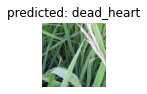

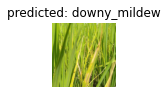

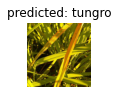

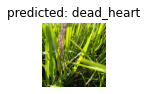

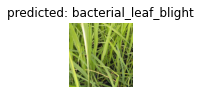

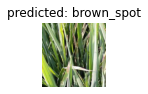

In [8]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

c:\Users\posky\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\posky\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and evaluate

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8501 Acc: 0.3612
val Loss: 1.5980 Acc: 0.4628

Epoch 1/24
----------
train Loss: 1.5684 Acc: 0.4677
val Loss: 1.4969 Acc: 0.4969

Epoch 2/24
----------
train Loss: 1.4713 Acc: 0.4948
val Loss: 1.4313 Acc: 0.5127

Epoch 3/24
----------
train Loss: 1.4136 Acc: 0.5227
val Loss: 1.3870 Acc: 0.5411

Epoch 4/24
----------
train Loss: 1.3930 Acc: 0.5293
val Loss: 1.3218 Acc: 0.5670

Epoch 5/24
----------
train Loss: 1.3446 Acc: 0.5426
val Loss: 1.3304 Acc: 0.5651

Epoch 6/24
----------
train Loss: 1.3323 Acc: 0.5440
val Loss: 1.2877 Acc: 0.5728

Epoch 7/24
----------
train Loss: 1.3025 Acc: 0.5563
val Loss: 1.2780 Acc: 0.5752

Epoch 8/24
----------
train Loss: 1.2906 Acc: 0.5669
val Loss: 1.2866 Acc: 0.5675

Epoch 9/24
----------
train Loss: 1.2982 Acc: 0.5622
val Loss: 1.2760 Acc: 0.5627

Epoch 10/24
----------
train Loss: 1.3009 Acc: 0.5573
val Loss: 1.2986 Acc: 0.5762

Epoch 11/24
----------
train Loss: 1.2946 Acc: 0.5603
val Loss: 1.2969 Acc: 0.5752

Ep

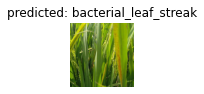

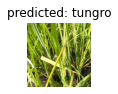

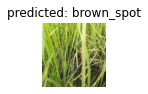

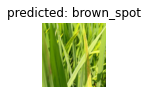

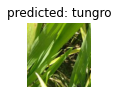

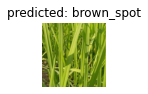

In [11]:
visualize_model(model_conv)